# Hybrid flow shop

The hybrid flow shop (HFS) is a common manufacturing environment in practice and widely studied by scheduling researchers. See for example the surveys by [Ruiz and Vázquez-Rodríguez (2010)](https://www.sciencedirect.com/science/article/pii/S0377221709006390) and [Ribas et al. (2010)](https://www.sciencedirect.com/science/article/pii/S0305054809002883) for an overview of HFS studies.

In this notebook, we demonstrate how to model and solve a HFS problem using PyJobShop.

## Problem description
The HFS problem is characterized as follows:

- There is a set of $n$ jobs that need to be processed in a series of stages.
- The number of processing stages is at least 2.
- Each stage has at least one machine in parallel, and in at least one stage there is more than one machine.
- All jobs are processed in the same production order: production starts in stage 1, then stage 2, etc. until the last stage. A job can only start processing when it has finished processing in the previous stage.

The figure below illustrates a small HFS example with three jobs and three stages. The first and third stage have three machines, and the second stage has two machines.

![HFS](../assets/hybrid-flow-shop.png "HFS")

We can model an HFS problem using PyJobShop. For each job, define for each stage $k$ one operation $o_k$. Moreover, we need to ensure that operation $o_{k-1}$ is processed before $o_k$, known as a precedence constraint.

Let's now implement the above example using PyJobShop's Model interface.

## Model

In [1]:
num_jobs = 3
num_stages = 3
num_machines = [3, 2, 3]

In [2]:
from pyjobshop import Model

model = Model()

The following will be helpful to plot names with $\LaTeX$ typesetting.

In [3]:
def machine_name(machine, stage):
    return f"$M_{{{machine}{stage}}}$"


def job_name(job: int, stage: int):
    return f"$J_{{{job}{stage}}}$"

First define the machine layout:

In [4]:
stage2machines = {}
for k in range(num_stages):
    stage2machines[k] = [
        model.add_machine(name=machine_name(m, k))
        for m in range(num_machines[k])
    ]

Now, we need to define jobs and the operations that have to be scheduled, along with the processing time data and precedence constraints, as mentioned earlier. The way to do this is with the `Model.add_constraint` methods, which allow us to impose constraints between any two operations. 

In [5]:
import random

from pyjobshop import Constraint

random.seed(42)

jobs = [model.add_job() for _ in range(num_jobs)]

for j, job in enumerate(jobs):
    operations = [
        model.add_operation(job=job, name=job_name(j, k))
        for k in range(num_stages)
    ]

    for stage in range(num_stages):
        for machine in stage2machines[stage]:
            duration = random.randint(1, 20)
            model.add_processing_time(machine, operations[stage], duration)

    for idx in range(num_stages - 1):
        first = operations[idx]
        second = operations[idx + 1]
        model.add_constraint(first, second, Constraint.END_BEFORE_START)

In [6]:
result = model.solve(log=True)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 44 variables, 38 constraints
 ! LogVerbosity         = Terse
 ! Initial process time : 0.02s (0.02s extraction + 0.00s propagation)
 !  . Log search space  : 63.6 (before), 63.6 (after)
 !  . Memory usage      : 573.7 kB (before), 573.7 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         44                 -
 + New bound is 16
 ! Using iterative diving.
 *            16        7  0.04s        1      (gap is 0.00%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! Best objective         : 16 (optimal - effective tol. is 0)
 ! Best bound             : 16
 ! ----------------------------------------------------------------------------
 ! Nu

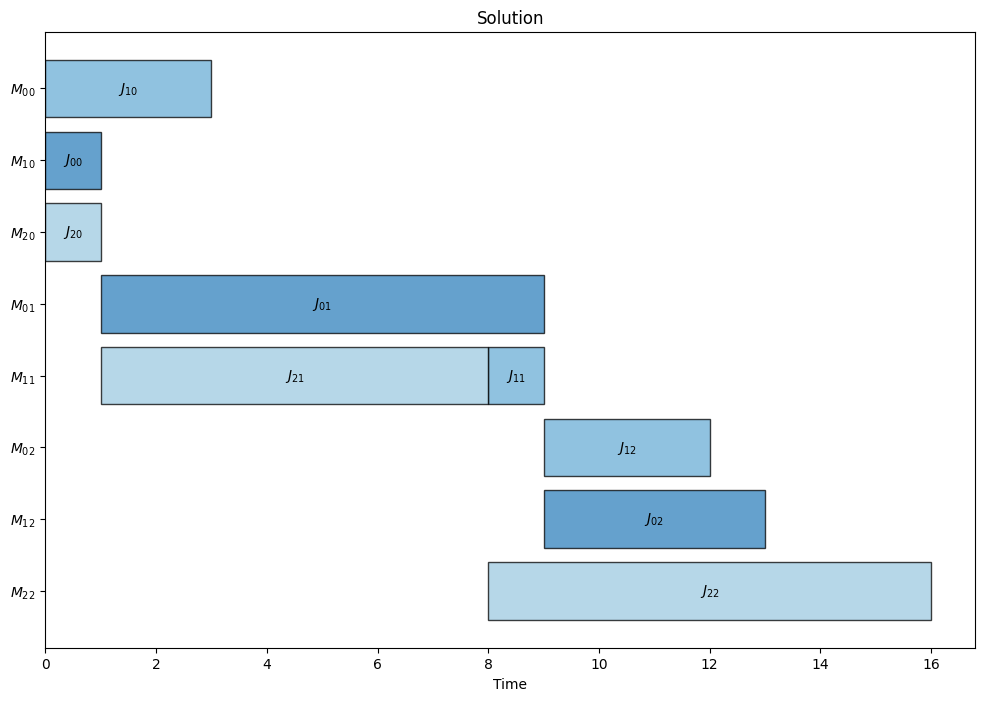

In [7]:
from pyjobshop import plot

data = model.data()
plot(data, result.best, plot_labels=True)

## Conclusion
This notebooks showed how to model and solve the hybrid flow shop problem using PyJobShop. Specifically, we show how to define the hybrid flow shop problem in terms of operations and how to add precedence constraints between operations.